# Simple Pitching Clustering by PitchType Percentage only

## Preprocess data

In [28]:
import pandas as pd
import glob
import os

root_dir = "./statcast_pitcher_data/"

all_dfs = []

# pattern: pitch_arsenals-rh-2020.csv
files = glob.glob(os.path.join(root_dir, "pitch_arsenals-*-*.csv"))

for filepath in files:
    # get filename only
    filename = os.path.basename(filepath)  # e.g., pitch_arsenals-rh-2020.csv
    
    # split using '-'
    parts = filename.replace(".csv", "").split("-")
    # parts → ["pitch_arsenals", "rh", "2020"]
    
    handedness_raw = parts[1]   # "rh" or "lh"
    year_raw = parts[2]         # "2020"... "2025"
    
    handedness = "R" if handedness_raw.lower() == "rh" else "L"
    year = int(year_raw)

    # load CSV
    df = pd.read_csv(filepath)

    # add columns
    df["year"] = year
    df["handedness"] = handedness

    all_dfs.append(df)

# combine into a single DataFrame
pitch_df = pd.concat(all_dfs, ignore_index=True)

# pitch_df.head()


In [29]:
pitch_df.fillna(0, inplace=True)
# pitch_df.head()

In [30]:
rename_map = {
    "n_ff": "four_seam",
    "n_si": "sinker",
    "n_fc": "cutter",
    "n_sl": "slider",
    "n_ch": "changeup",
    "n_cu": "curveball",
    "n_fs": "splitter",
    "n_kn": "knuckleball",
    "n_st": "sweeper",
    "n_sv": "screwball"
}

pitch_df = pitch_df.rename(columns=rename_map)
pitch_df.head()

,"last_name, first_name",pitcher,four_seam,sinker,cutter,slider,changeup,curveball,splitter,knuckleball,sweeper,screwball,year,handedness
0,"Rodriguez, Eduardo",593958,38.7,15.8,16.2,2.4,23.7,3.2,0.0,0.0,0.0,0.0,2019,L
1,"Minor, Mike",501985,44.6,0.0,0.0,19.4,24.6,11.4,0.0,0.0,0.0,0.0,2019,L
2,"Corbin, Patrick",571578,19.4,34.3,0.0,37.1,5.7,3.5,0.0,0.0,0.0,0.0,2019,L
3,"Bumgarner, Madison",518516,42.8,0.1,33.4,0.0,5.3,18.3,0.0,0.0,0.0,0.0,2019,L
4,"Gonzales, Marco",594835,39.4,0.0,20.7,0.0,24.1,15.9,0.0,0.0,0.0,0.0,2019,L


## Clustering by pitch usage only

### K Means Clustering

In [31]:
import numpy as np

pitch_cols = [
    "four_seam", "sinker", "cutter", "slider", "changeup",
    "curveball", "splitter", "knuckleball", "sweeper", "screwball"
]

# total pitches per pitcher
pitch_df["total_pitches"] = pitch_df[pitch_cols].sum(axis=1)

# drop pitchers with no pitches (just in case)
pitch_df = pitch_df[pitch_df["total_pitches"] > 0].copy()

# convert to percentages
for col in pitch_cols:
    pitch_df[col + "_pct"] = pitch_df[col] / pitch_df["total_pitches"]

feature_cols = [c + "_pct" for c in pitch_cols]

X = pitch_df[feature_cols].values


In [32]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)


In [33]:
# X_used = X_scaled  # or X if you skip StandardScaler
X_used = X  # if you skip StandardScaler

KMeans k=2: silhouette=0.2983
KMeans k=3: silhouette=0.2308
KMeans k=4: silhouette=0.2142
KMeans k=5: silhouette=0.1996
KMeans k=6: silhouette=0.2076
KMeans k=7: silhouette=0.1969
KMeans k=8: silhouette=0.1930
KMeans k=9: silhouette=0.1964
KMeans k=10: silhouette=0.1987


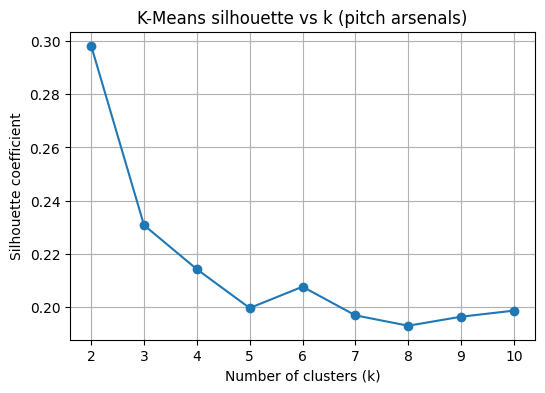

Best k for KMeans: 2


In [34]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

k_values = range(2, 11)  # try 2..10 clusters
sil_scores_kmeans = []

for k in k_values:
    kmeans = KMeans(
        n_clusters=k,
        n_init=10,
        random_state=42
    )
    labels = kmeans.fit_predict(X_used)
    score = silhouette_score(X_used, labels)
    sil_scores_kmeans.append(score)
    print(f"KMeans k={k}: silhouette={score:.4f}")

# plot silhouette vs k
plt.figure(figsize=(6, 4))
plt.plot(list(k_values), sil_scores_kmeans, marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette coefficient")
plt.title("K-Means silhouette vs k (pitch arsenals)")
plt.grid(True)
plt.show()

# fit final KMeans at best k
best_k_kmeans = k_values[int(np.argmax(sil_scores_kmeans))]
print("Best k for KMeans:", best_k_kmeans)

kmeans_final = KMeans(
    n_clusters=best_k_kmeans,
    n_init=10,
    random_state=42
)
pitch_df["kmeans_cluster"] = kmeans_final.fit_predict(X_used)


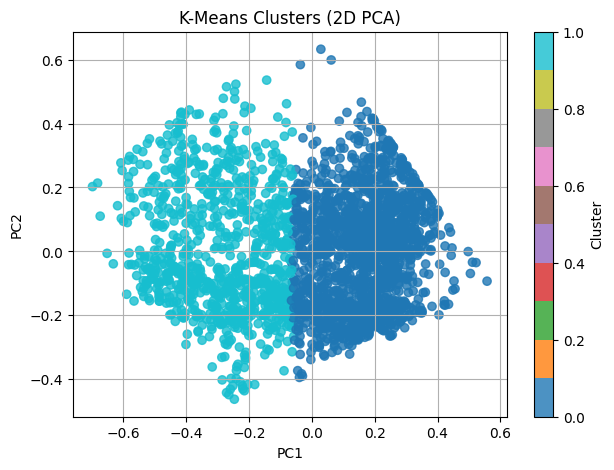

In [35]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Assuming X_used is your standardized/normalized matrix
pca_2d = PCA(n_components=2)
X_2d = pca_2d.fit_transform(X_used)

plt.figure(figsize=(7,5))
scatter = plt.scatter(
    X_2d[:,0], X_2d[:,1],
    c=pitch_df["kmeans_cluster"],
    cmap="tab10",
    alpha=0.8
)
plt.title("K-Means Clusters (2D PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.colorbar(scatter, label="Cluster")
plt.show()


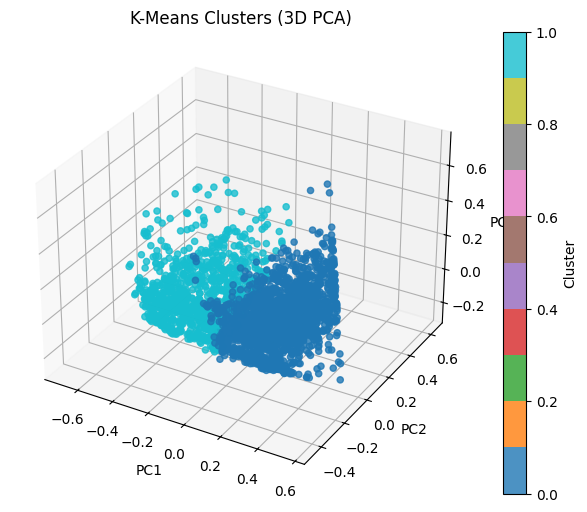

In [36]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

pca_3d = PCA(n_components=3)
X_3d = pca_3d.fit_transform(X_used)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    X_3d[:,0], X_3d[:,1], X_3d[:,2],
    c=pitch_df["kmeans_cluster"],
    cmap="tab10",
    alpha=0.8
)

ax.set_title("K-Means Clusters (3D PCA)")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")

fig.colorbar(scatter, label="Cluster")
plt.show()


### HAC Clustering

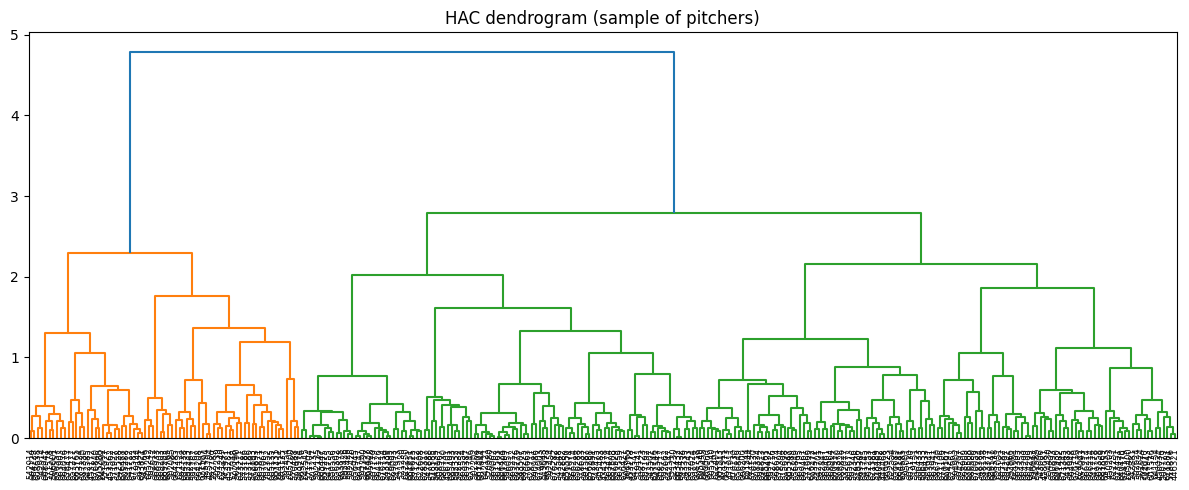

In [37]:
from scipy.cluster.hierarchy import linkage, dendrogram

# sample some pitchers for dendrogram (to avoid 5k tiny labels)
max_sample = 300
if len(pitch_df) > max_sample:
    sample_idx = np.random.choice(pitch_df.index, size=max_sample, replace=False)
else:
    sample_idx = pitch_df.index

X_sample = X_used[pitch_df.index.get_indexer(sample_idx)]

Z = linkage(X_sample, method="ward")  

plt.figure(figsize=(12, 5))
dendrogram(
    Z,
    labels=pitch_df.loc[sample_idx, "pitcher"].astype(str).values,
    leaf_rotation=90,
    leaf_font_size=6,
)
plt.title("HAC dendrogram (sample of pitchers)")
plt.tight_layout()
plt.show()


HAC k=2: silhouette=0.2845
HAC k=3: silhouette=0.2139
HAC k=4: silhouette=0.2027
HAC k=5: silhouette=0.1278
HAC k=6: silhouette=0.1180
HAC k=7: silhouette=0.1291
HAC k=8: silhouette=0.1394
HAC k=9: silhouette=0.1447
HAC k=10: silhouette=0.1478


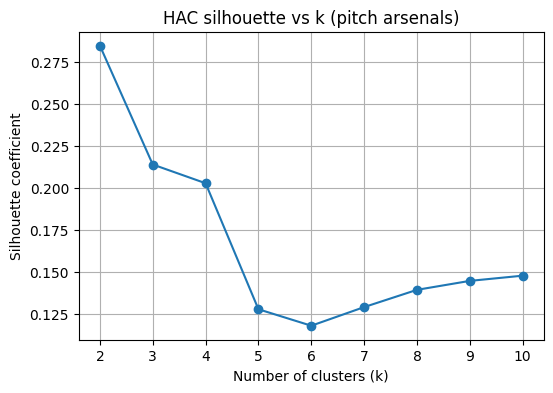

Best k for HAC: 2


In [38]:
from sklearn.cluster import AgglomerativeClustering

sil_scores_hac = []

for k in k_values:
    hac = AgglomerativeClustering(
        n_clusters=k,
        linkage="ward"
    )
    labels = hac.fit_predict(X_used)
    score = silhouette_score(X_used, labels)
    sil_scores_hac.append(score)
    print(f"HAC k={k}: silhouette={score:.4f}")

plt.figure(figsize=(6, 4))
plt.plot(list(k_values), sil_scores_hac, marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette coefficient")
plt.title("HAC silhouette vs k (pitch arsenals)")
plt.grid(True)
plt.show()

best_k_hac = k_values[int(np.argmax(sil_scores_hac))]
print("Best k for HAC:", best_k_hac)

hac_final = AgglomerativeClustering(
    n_clusters=best_k_hac,
    linkage="ward"
)
pitch_df["hac_cluster"] = hac_final.fit_predict(X_used)


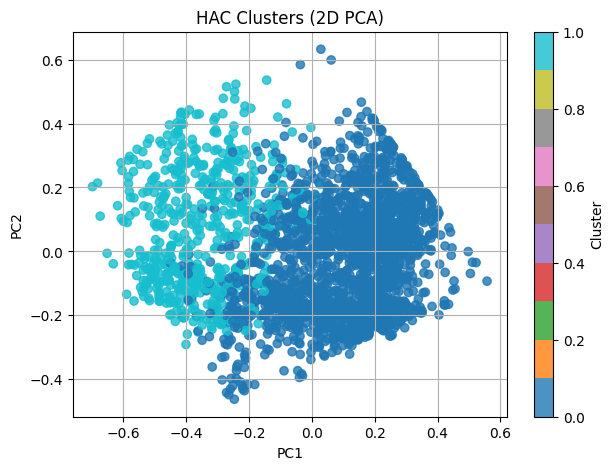

In [39]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca_2d = PCA(n_components=2)
X_2d = pca_2d.fit_transform(X_used)

plt.figure(figsize=(7,5))
scatter = plt.scatter(
    X_2d[:,0], X_2d[:,1],
    c=pitch_df["hac_cluster"],
    cmap="tab10",
    alpha=0.8
)
plt.title("HAC Clusters (2D PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.colorbar(scatter, label="Cluster")
plt.show()


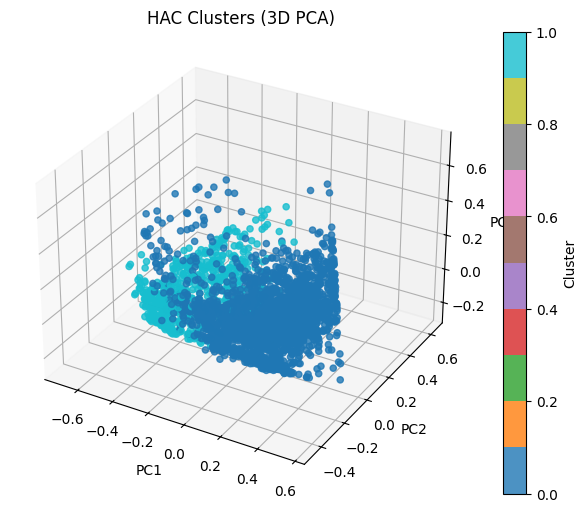

In [40]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

pca_3d = PCA(n_components=3)
X_3d = pca_3d.fit_transform(X_used)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    X_3d[:,0], X_3d[:,1], X_3d[:,2],
    c=pitch_df["hac_cluster"],
    cmap="tab10",
    alpha=0.8
)

ax.set_title("HAC Clusters (3D PCA)")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")

fig.colorbar(scatter, label="Cluster")
plt.show()


### Determining names of clusters

In [41]:
pitch_df[["last_name, first_name", "pitcher", "year", "kmeans_cluster"]].head()

,"last_name, first_name",pitcher,year,kmeans_cluster
0,"Rodriguez, Eduardo",593958,2019,0
1,"Minor, Mike",501985,2019,0
2,"Corbin, Patrick",571578,2019,1
3,"Bumgarner, Madison",518516,2019,0
4,"Gonzales, Marco",594835,2019,0


In [42]:
pitch_df.sort_values("kmeans_cluster").head(20)


,"last_name, first_name",pitcher,four_seam,sinker,cutter,slider,changeup,curveball,splitter,knuckleball,...,cutter_pct,slider_pct,changeup_pct,curveball_pct,splitter_pct,knuckleball_pct,sweeper_pct,screwball_pct,kmeans_cluster,hac_cluster
14,"Means, John",607644,50.7,0.0,0.0,14.4,28.9,1.8,0.0,0.0,...,0.000000,0.144144,0.289289,0.018018,0.000000,0.0,0.000,0.041041,0,0
13,"Happ, J.A.",457918,48.4,17.5,0.0,17.4,15.9,0.8,0.0,0.0,...,0.000000,0.174000,0.159000,0.008000,0.000000,0.0,0.000,0.000000,0,0
10,"Quintana, Jose",500779,36.3,25.5,0.0,0.0,11.0,21.9,0.0,0.0,...,0.000000,0.000000,0.110000,0.219000,0.000000,0.0,0.000,0.053000,0,0
6,"Ray, Robbie",592662,42.7,10.0,0.0,30.8,0.0,16.5,0.0,0.0,...,0.000000,0.308000,0.000000,0.165000,0.000000,0.0,0.000,0.000000,0,0
5,"Boyd, Matthew",571510,49.8,3.9,0.0,36.2,6.1,4.0,0.0,0.0,...,0.000000,0.362000,0.061000,0.040000,0.000000,0.0,0.000,0.000000,0,0
4,"Gonzales, Marco",594835,39.4,0.0,20.7,0.0,24.1,15.9,0.0,0.0,...,0.206793,0.000000,0.240759,0.158841,0.000000,0.0,0.000,0.000000,0,0
3,"Bumgarner, Madison",518516,42.8,0.1,33.4,0.0,5.3,18.3,0.0,0.0,...,0.334334,0.000000,0.053053,0.183183,0.000000,0.0,0.000,0.000000,0,0
1586,"Wick, Rowan",592858,55.8,0.2,17.2,5.3,0.1,21.4,0.0,0.0,...,0.172000,0.053000,0.001000,0.214000,0.000000,0.0,0.000,0.000000,0,0
1585,"Phelps, David",475479,29.7,11.7,24.7,0.0,7.5,26.4,0.0,0.0,...,0.247000,0.000000,0.075000,0.264000,0.000000,0.0,0.000,0.000000,0,0
1584,"Jax, Griffin",643377,33.6,0.1,0.0,0.0,13.7,4.2,0.0,0.0,...,0.000000,0.000000,0.137000,0.042000,0.000000,0.0,0.484,0.000000,0,0


In [43]:
pitch_df[pitch_df.kmeans_cluster == 0]


,"last_name, first_name",pitcher,four_seam,sinker,cutter,slider,changeup,curveball,splitter,knuckleball,...,cutter_pct,slider_pct,changeup_pct,curveball_pct,splitter_pct,knuckleball_pct,sweeper_pct,screwball_pct,kmeans_cluster,hac_cluster
0,"Rodriguez, Eduardo",593958,38.7,15.8,16.2,2.4,23.7,3.2,0.0,0.0,...,0.162000,0.024000,0.237000,0.032000,0.000000,0.0,0.000000,0.0,0,0
1,"Minor, Mike",501985,44.6,0.0,0.0,19.4,24.6,11.4,0.0,0.0,...,0.000000,0.194000,0.246000,0.114000,0.000000,0.0,0.000000,0.0,0,0
3,"Bumgarner, Madison",518516,42.8,0.1,33.4,0.0,5.3,18.3,0.0,0.0,...,0.334334,0.000000,0.053053,0.183183,0.000000,0.0,0.000000,0.0,0,0
4,"Gonzales, Marco",594835,39.4,0.0,20.7,0.0,24.1,15.9,0.0,0.0,...,0.206793,0.000000,0.240759,0.158841,0.000000,0.0,0.000000,0.0,0,0
5,"Boyd, Matthew",571510,49.8,3.9,0.0,36.2,6.1,4.0,0.0,0.0,...,0.000000,0.362000,0.061000,0.040000,0.000000,0.0,0.000000,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2477,"Fisher, Braydon",680755,22.1,0.0,3.0,38.3,0.0,36.6,0.0,0.0,...,0.030000,0.383000,0.000000,0.366000,0.000000,0.0,0.000000,0.0,0,0
2479,"Myers, Tobias",668964,45.2,0.0,19.5,16.8,1.5,1.5,15.6,0.0,...,0.194805,0.167832,0.014985,0.014985,0.155844,0.0,0.000000,0.0,0,0
2481,"Morales, Luis",806960,52.4,0.0,0.0,8.0,13.0,0.0,0.0,0.0,...,0.000000,0.080000,0.130000,0.000000,0.000000,0.0,0.266000,0.0,0,0
2482,"Beck, Tristan",663941,33.0,0.0,0.0,21.3,0.0,17.3,0.0,0.0,...,0.000000,0.213000,0.000000,0.173000,0.000000,0.0,0.284000,0.0,0,0


In [44]:
pitch_df.groupby("hac_cluster")[feature_cols].mean()


,four_seam_pct,sinker_pct,cutter_pct,slider_pct,changeup_pct,curveball_pct,splitter_pct,knuckleball_pct,sweeper_pct,screwball_pct
hac_cluster,,,,,,,,,,
0,0.407061,0.075371,0.078334,0.164431,0.105663,0.098111,0.026480,0.000290,0.042087,0.002172
1,0.102859,0.425358,0.066308,0.166030,0.104730,0.074952,0.011323,0.000147,0.040956,0.007337


In [45]:
pitch_df.groupby("kmeans_cluster")[feature_cols].mean()


,four_seam_pct,sinker_pct,cutter_pct,slider_pct,changeup_pct,curveball_pct,splitter_pct,knuckleball_pct,sweeper_pct,screwball_pct
kmeans_cluster,,,,,,,,,,
0,0.456402,0.049874,0.050546,0.181571,0.104162,0.095387,0.027141,0.000111,0.032642,0.002164
1,0.130338,0.338996,0.119460,0.135422,0.107707,0.088390,0.015839,0.000515,0.057915,0.005418


In [46]:
cluster_name_map = {
    0: "Four-Seam & Slider Dominant (North–South Power Arms)",
    1: "Sinker & Cutter Dominant (East–West Movement Arms)"
}

pitch_df["hac_archetype"] = pitch_df["hac_cluster"].map(cluster_name_map)

In [47]:
pitch_df[[
    "last_name, first_name",
    "hac_archetype"
]].head(20)


,"last_name, first_name",hac_archetype
0,"Rodriguez, Eduardo",Four-Seam & Slider Dominant (North–South Power...
1,"Minor, Mike",Four-Seam & Slider Dominant (North–South Power...
2,"Corbin, Patrick",Sinker & Cutter Dominant (East–West Movement A...
3,"Bumgarner, Madison",Four-Seam & Slider Dominant (North–South Power...
4,"Gonzales, Marco",Four-Seam & Slider Dominant (North–South Power...
5,"Boyd, Matthew",Four-Seam & Slider Dominant (North–South Power...
6,"Ray, Robbie",Four-Seam & Slider Dominant (North–South Power...
7,"Lester, Jon",Four-Seam & Slider Dominant (North–South Power...
8,"Miley, Wade",Four-Seam & Slider Dominant (North–South Power...
9,"Pérez, Martín",Four-Seam & Slider Dominant (North–South Power...


In [48]:
pitch_df[pitch_df["last_name, first_name"].str.contains("Yamamoto", case=False)]


,"last_name, first_name",pitcher,four_seam,sinker,cutter,slider,changeup,curveball,splitter,knuckleball,...,slider_pct,changeup_pct,curveball_pct,splitter_pct,knuckleball_pct,sweeper_pct,screwball_pct,kmeans_cluster,hac_cluster,hac_archetype
783,"Yamamoto, Jordan",657141,49.0,0.8,18.0,14.8,3.6,13.8,0.0,0.0,...,0.148000,0.036,0.138000,0.000000,0.0,0.000,0.0,0,0,Four-Seam & Slider Dominant (North–South Power...
2077,"Yamamoto, Yoshinobu",808967,40.5,2.8,6.1,3.2,0.0,23.1,24.2,0.0,...,0.032000,0.000,0.231000,0.242000,0.0,0.001,0.0,0,0,Four-Seam & Slider Dominant (North–South Power...
2260,"Yamamoto, Yoshinobu",808967,35.6,7.5,11.0,2.8,0.0,17.6,25.4,0.0,...,0.028028,0.000,0.176176,0.254254,0.0,0.000,0.0,0,0,Four-Seam & Slider Dominant (North–South Power...


## Clustering by pitchtype weighted by pitch value (runs per 100 pitches)

In [49]:
pitch_code_to_stat = {
    "FF": "four_seam_rv100",
    "SI": "sinker_rv100",
    "CH": "changeup_rv100",
    "SL": "slider_rv100",
    "CU": "curveball_rv100",
    "FS": "splitter_rv100",
    "FC": "cutter_rv100",
    "SV": "screwball_rv100",
    "ST": "sweeper_rv100"
}


In [50]:
pitch_code_to_pct = {
    "FF": "four_seam_pct",
    "SI": "sinker_pct",
    "CH": "changeup_pct",
    "SL": "slider_pct",
    "CU": "curveball_pct",
    "FS": "splitter_pct",
    "FC": "cutter_pct",
    "SV": "screwball_pct",
    "ST": "sweeper_pct"
}


In [51]:
import pandas as pd
import glob
import os

root_dir = "./statcast_pitcher_data/"

pitch_code_to_pct = {
    "FF": "four_seam_pct",
    "SI": "sinker_pct",
    "CH": "changeup_pct",
    "SL": "slider_pct",
    "CU": "curveball_pct",
    "FS": "splitter_pct",
    "FC": "cutter_pct",
    "SV": "screwball_pct",
    "ST": "sweeper_pct"
}

pitch_code_to_stat = {
    code: pct.replace("_pct", "_rv100")
    for code, pct in pitch_code_to_pct.items()
}

# --- Load stats files
stats_files = glob.glob(os.path.join(root_dir, "pitch-arsenal-stats-*.csv"))

stats_list = []
for filepath in stats_files:
    filename = os.path.basename(filepath)
    year = int(filename.replace(".csv", "").split("-")[-1])

    df = pd.read_csv(filepath)
    df["year"] = year

    # Add smooth rv100
    df["rv100_smooth"] = df["run_value"] / (df["pitches"] + 700) * 100

    stats_list.append(df)

stats_df = pd.concat(stats_list, ignore_index=True)

# # --- Pivot stats into one row per pitcher/year
# stats_pivot = stats_df.pivot_table(
#     index=["player_id", "year"],
#     columns="pitch_type",
#     values="run_value_per_100"
# ).reset_index()

# --- Pivot stats into one row per pitcher/year
stats_pivot = stats_df.pivot_table(
    index=["player_id", "year"],
    columns="pitch_type",
    values="rv100_smooth"
).reset_index()

# Rename stat columns
stats_pivot = stats_pivot.rename(columns=pitch_code_to_stat)

# Fill missing stats
# stats_pivot = stats_pivot.fillna(0)

# --- Merge mix + stats
merged = pitch_df.merge(
    stats_pivot,
    left_on=["pitcher", "year"],
    right_on=["player_id", "year"],
    how="left"
)

# merged = merged.fillna(0)

# --- Create weighted values
weighted_feature_cols = []

for code, pct_col in pitch_code_to_pct.items():
    stat_col = pitch_code_to_stat[code]
    value_col = pct_col.replace("_pct", "_value")
    
    merged[value_col] = merged[pct_col] * -merged[stat_col] *100
    weighted_feature_cols.append(value_col)

# --- Final weighted_df
weighted_df = merged[
    ["pitcher", "year", "handedness", "last_name, first_name"] +
    weighted_feature_cols
].copy()

# weighted_df = weighted_df.fillna(0)


In [52]:
weighted_df.head()


,pitcher,year,handedness,"last_name, first_name",four_seam_value,sinker_value,changeup_value,slider_value,curveball_value,splitter_value,cutter_value,screwball_value,sweeper_value
0,593958,2019,L,"Rodriguez, Eduardo",-11.304771,-6.314948,-7.745098,NaN,NaN,NaN,-8.964427,NaN,NaN
1,501985,2019,L,"Minor, Mike",-26.390533,NaN,-37.077326,14.359734,NaN,NaN,NaN,NaN,NaN
2,571578,2019,L,"Corbin, Patrick",2.893363,-11.245902,NaN,-38.565489,NaN,NaN,NaN,NaN,NaN
3,518516,2019,L,"Bumgarner, Madison",-12.317061,NaN,NaN,NaN,-11.325081,NaN,-7.504699,NaN,NaN
4,594835,2019,L,"Gonzales, Marco",-4.045287,NaN,-4.943722,NaN,1.321474,NaN,-0.000000,NaN,NaN


### K-Means

In [53]:
import numpy as np

weighted_cols = [c for c in weighted_df.columns if c.endswith("_value")]

X_weighted = weighted_df[weighted_cols].values

# Optional: fill any tiny numerical NaNs (shouldn't be any)
X_weighted = np.nan_to_num(X_weighted)


KMeans k=2: silhouette=0.3826
KMeans k=3: silhouette=0.3458
KMeans k=4: silhouette=0.3759
KMeans k=5: silhouette=0.4032
KMeans k=6: silhouette=0.4000
KMeans k=7: silhouette=0.3580
KMeans k=8: silhouette=0.3749
KMeans k=9: silhouette=0.3876
KMeans k=10: silhouette=0.3858


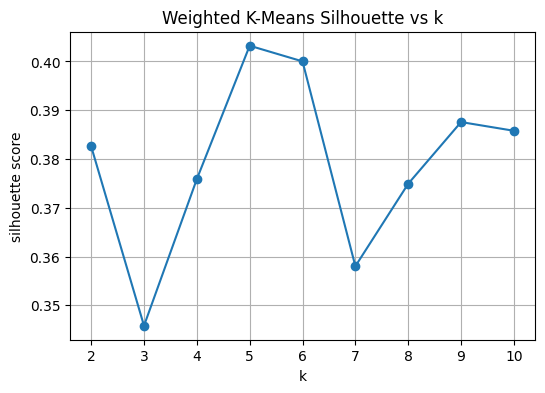

Best weighted k (K-Means): 5


In [54]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

k_values = range(2, 11)
sil_scores_kmeans = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = kmeans.fit_predict(X_weighted)
    score = silhouette_score(X_weighted, labels)
    sil_scores_kmeans.append(score)
    print(f"KMeans k={k}: silhouette={score:.4f}")

plt.figure(figsize=(6,4))
plt.plot(k_values, sil_scores_kmeans, marker="o")
plt.title("Weighted K-Means Silhouette vs k")
plt.xlabel("k")
plt.ylabel("silhouette score")
plt.grid(True)
plt.show()

best_k_kmeans = k_values[int(np.argmax(sil_scores_kmeans))]
print("Best weighted k (K-Means):", best_k_kmeans)

# Save labels
kmeans_final = KMeans(n_clusters=best_k_kmeans, n_init=10, random_state=42)
weighted_df["kmeans_weighted_cluster"] = kmeans_final.fit_predict(X_weighted)


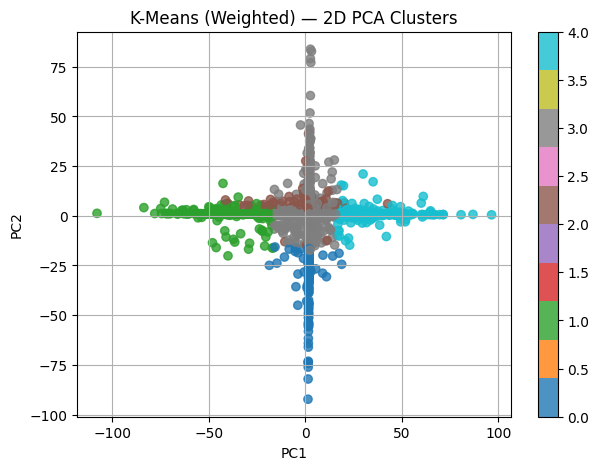

In [55]:
from sklearn.decomposition import PCA

pca2 = PCA(n_components=2)
X2 = pca2.fit_transform(X_weighted)

plt.figure(figsize=(7,5))
plt.scatter(X2[:,0], X2[:,1], c=weighted_df["kmeans_weighted_cluster"], cmap="tab10", alpha=0.8)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("K-Means (Weighted) — 2D PCA Clusters")
plt.grid(True)
plt.colorbar()
plt.show()


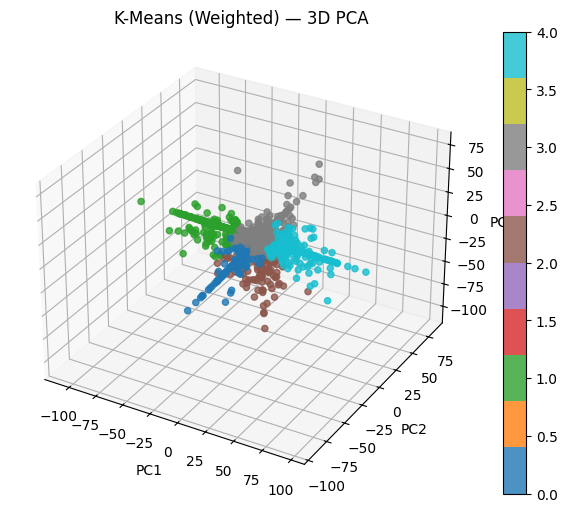

In [56]:
from mpl_toolkits.mplot3d import Axes3D

pca3 = PCA(n_components=3)
X3 = pca3.fit_transform(X_weighted)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    X3[:,0], X3[:,1], X3[:,2],
    c=weighted_df["kmeans_weighted_cluster"],
    cmap="tab10",
    alpha=0.8
)

ax.set_title("K-Means (Weighted) — 3D PCA")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")

plt.colorbar(scatter)
plt.show()


### HAC

HAC k=2: silhouette=0.3175
HAC k=3: silhouette=0.2624
HAC k=4: silhouette=0.2923
HAC k=5: silhouette=0.3037
HAC k=6: silhouette=0.2821
HAC k=7: silhouette=0.2972
HAC k=8: silhouette=0.3081
HAC k=9: silhouette=0.3031
HAC k=10: silhouette=0.3156


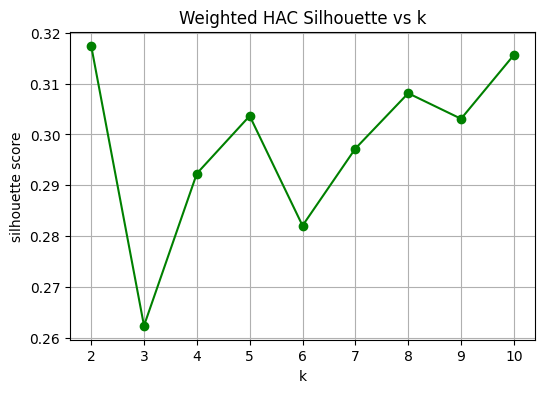

Best weighted k (HAC): 2


In [57]:
from sklearn.cluster import AgglomerativeClustering

sil_scores_hac = []

for k in k_values:
    hac = AgglomerativeClustering(n_clusters=k, linkage="ward")
    labels = hac.fit_predict(X_weighted)
    score = silhouette_score(X_weighted, labels)
    sil_scores_hac.append(score)
    print(f"HAC k={k}: silhouette={score:.4f}")

plt.figure(figsize=(6,4))
plt.plot(k_values, sil_scores_hac, marker="o", color="green")
plt.title("Weighted HAC Silhouette vs k")
plt.xlabel("k")
plt.ylabel("silhouette score")
plt.grid(True)
plt.show()

best_k_hac = k_values[int(np.argmax(sil_scores_hac))]
print("Best weighted k (HAC):", best_k_hac)

weighted_df["hac_weighted_cluster"] = AgglomerativeClustering(
    n_clusters=best_k_hac,
    linkage="ward"
).fit_predict(X_weighted)


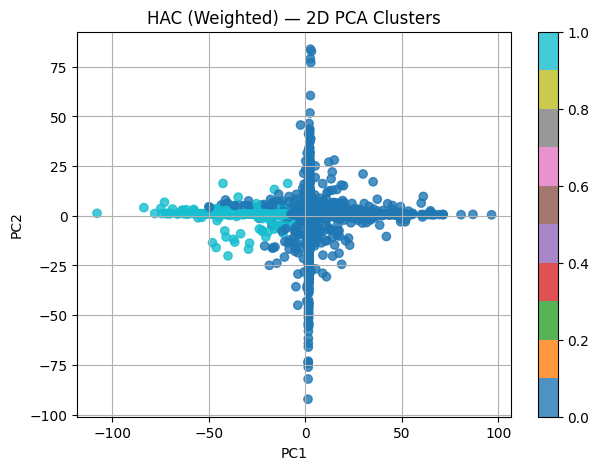

In [58]:
plt.figure(figsize=(7,5))
plt.scatter(X2[:,0], X2[:,1], c=weighted_df["hac_weighted_cluster"], cmap="tab10", alpha=0.8)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("HAC (Weighted) — 2D PCA Clusters")
plt.grid(True)
plt.colorbar()
plt.show()


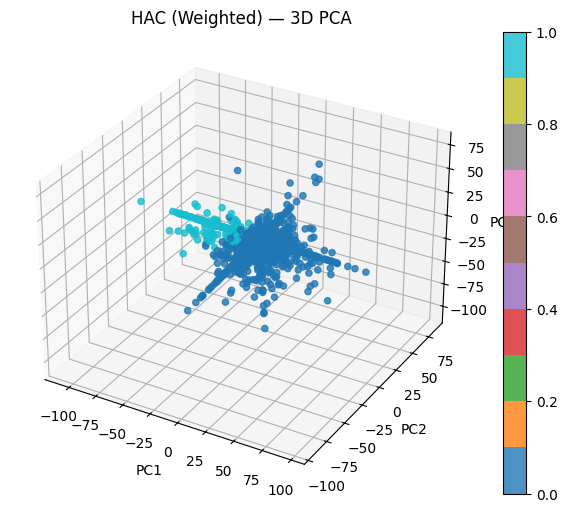

In [59]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    X3[:,0], X3[:,1], X3[:,2],
    c=weighted_df["hac_weighted_cluster"],
    cmap="tab10",
    alpha=0.8
)

ax.set_title("HAC (Weighted) — 3D PCA")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")

plt.colorbar(scatter)
plt.show()


### Finding cluster names

In [60]:
weighted_df.groupby("kmeans_weighted_cluster")[weighted_cols].mean()


,four_seam_value,sinker_value,changeup_value,slider_value,curveball_value,splitter_value,cutter_value,screwball_value,sweeper_value
kmeans_weighted_cluster,,,,,,,,,
0,-2.233353,-34.570655,-2.142549,-7.955178,-7.004408,-11.768336,-4.704993,-5.163957,-6.255337
1,-36.700318,-7.268327,-5.972656,-7.569733,-6.836150,-8.381276,-7.314209,-11.979087,-6.327954
2,-4.640316,0.721615,-5.686474,-36.905973,-9.600964,-6.661925,3.034623,NaN,-12.027491
3,-2.508081,4.265963,-9.331348,-1.750404,-5.435063,-13.793231,-7.810412,-10.851823,-10.165148
4,28.844464,-0.197984,-3.414831,-3.054100,-3.515735,-1.100522,1.968969,-10.135779,-4.689110


In [61]:
weighted_cluster_names = {
    4: "Four-Seam Fastball Aces",
    1: "Balanced Workhorse Starters",
    0: "Sinker-Heavy but Ineffective",
    2: "Slider-Heavy but Ineffective",
    3: "Offspeed-Heavy but Ineffective (Changeup/Splitter)"
}

weighted_df["weighted_archetype"] = (
    weighted_df["kmeans_weighted_cluster"].map(weighted_cluster_names)
)


## Cluster using xwoba for quality

In [62]:
import pandas as pd
import glob
import os

root_dir = "./statcast_pitcher_data/"

pitch_code_to_pct = {
    "FF": "four_seam_pct",
    "SI": "sinker_pct",
    "CH": "changeup_pct",
    "SL": "slider_pct",
    "CU": "curveball_pct",
    "FS": "splitter_pct",
    "FC": "cutter_pct",
    "SV": "screwball_pct",
    "ST": "sweeper_pct"
}

pitch_code_to_stat = {
    code: pct.replace("_pct", "_rv100")
    for code, pct in pitch_code_to_pct.items()
}

# --- Load stats files
stats_files = glob.glob(os.path.join(root_dir, "pitch-arsenal-stats-*.csv"))

stats_df = []
stats_list = []
for filepath in stats_files:
    filename = os.path.basename(filepath)
    year = int(filename.replace(".csv", "").split("-")[-1])

    df = pd.read_csv(filepath)
    df["year"] = year

    stats_list.append(df)

stats_df = pd.concat(stats_list, ignore_index=True)


# --- Pivot stats into one row per pitcher/year
# stats_pivot = stats_df.pivot_table(
#     index=["player_id", "year"],
#     columns=["pitch_type", "pitch_usage", "est_woba"]
#     # values="rv100_smooth"
# ).reset_index()

stats_pivot = stats_df[["last_name, first_name", "player_id", "year", "pitch_type", "pitch_usage", "est_woba"]]

stats_pivot.head()

# # Rename stat columns
# stats_pivot = stats_pivot.rename(columns=pitch_code_to_stat)

# # Fill missing stats
# # stats_pivot = stats_pivot.fillna(0)

# # --- Merge mix + stats
# merged = pitch_df.merge(
#     stats_pivot,
#     left_on=["pitcher", "year"],
#     right_on=["player_id", "year"],
#     how="left"
# )

# # merged = merged.fillna(0)

# # --- Create weighted values
# weighted_feature_cols = []

# for code, pct_col in pitch_code_to_pct.items():
#     stat_col = pitch_code_to_stat[code]
#     value_col = pct_col.replace("_pct", "_value")
    
#     merged[value_col] = merged[pct_col] * -merged[stat_col] *100
#     weighted_feature_cols.append(value_col)

# # --- Final weighted_df
# weighted_df = merged[
#     ["pitcher", "year", "handedness", "last_name, first_name"] +
#     weighted_feature_cols
# ].copy()

# # weighted_df = weighted_df.fillna(0)

stats_pivot.columns

Index(['last_name, first_name', 'player_id', 'year', 'pitch_type',
       'pitch_usage', 'est_woba'],
      dtype='object')

In [63]:
import pandas as pd

# Your current df
stats_pivot = stats_df[[
    "last_name, first_name", 
    "player_id", 
    "year", 
    "pitch_type", 
    "pitch_usage", 
    "est_woba"
]]

# --- Pivot usage %
usage_wide = stats_pivot.pivot_table(
    index=["player_id", "year", "last_name, first_name"],
    columns="pitch_type",
    values="pitch_usage",
    # aggfunc="sum"  # or mean (doesn't matter because one row per pitch_type)
)

# Rename columns to *_pct
usage_wide = usage_wide.add_suffix("_pct")

# --- Pivot xwOBA
xwoba_wide = stats_pivot.pivot_table(
    index=["player_id", "year", "last_name, first_name"],
    columns="pitch_type",
    values="est_woba",
    # aggfunc="mean"
)

# Rename columns to *_xwoba
xwoba_wide = xwoba_wide.add_suffix("_xwoba")

# --- Merge usage + xwoba
final_pitch_table = usage_wide.join(xwoba_wide).reset_index()

# Optional: Fill missing values with 0
# final_pitch_table = final_pitch_table.fillna(0)

final_pitch_table.columns.to_list()


['player_id',
 'year',
 'last_name, first_name',
 'CH_pct',
 'CU_pct',
 'FC_pct',
 'FF_pct',
 'FS_pct',
 'KN_pct',
 'SI_pct',
 'SL_pct',
 'ST_pct',
 'SV_pct',
 'CH_xwoba',
 'CU_xwoba',
 'FC_xwoba',
 'FF_xwoba',
 'FS_xwoba',
 'KN_xwoba',
 'SI_xwoba',
 'SL_xwoba',
 'ST_xwoba',
 'SV_xwoba']

In [64]:
# Compute league average xwOBA per (year, pitch_type)
league_avg_pt = (
    stats_df
    .groupby(["year", "pitch_type"])["est_woba"]
    .mean()
    .rename("league_avg_xwoba")
    .reset_index()
)

# league_avg_pt[league_avg_pt["year"] == 2025].head()

stats2 = stats_df.merge(
    league_avg_pt,
    on=["year", "pitch_type"],
    how="left"
)

# stats2.columns.to_list()

stats2["quality"] = stats2["league_avg_xwoba"] - stats2["est_woba"]

# Compute mean & std of quality globally per pitch type
pt_stats = (
    stats2.groupby("pitch_type")["quality"]
    .agg(["mean", "std"])
    .rename(columns={"mean": "qmean", "std": "qstd"})
    .reset_index()
)

# Merge into main table
stats3 = stats2.merge(pt_stats, on="pitch_type", how="left")

# Compute global z-score per pitch type
stats3["quality_scaled"] = (stats3["quality"] - stats3["qmean"]) / stats3["qstd"]


In [65]:
# Pivot usage
usage_wide = stats3.pivot_table(
    index=["player_id", "year", "last_name, first_name"],
    columns="pitch_type",
    values="pitch_usage",
    aggfunc="sum"
).add_suffix("_pct")

# Pivot xwOBA
xwoba_wide = stats3.pivot_table(
    index=["player_id", "year", "last_name, first_name"],
    columns="pitch_type",
    values="est_woba",
    aggfunc="mean"
).add_suffix("_xwoba")

# Pivot quality
quality_wide = stats3.pivot_table(
    index=["player_id", "year", "last_name, first_name"],
    columns="pitch_type",
    values="quality",
    aggfunc="mean"
).add_suffix("_quality")

# Pivot scaled quality
scaled_wide = stats3.pivot_table(
    index=["player_id", "year", "last_name, first_name"],
    columns="pitch_type",
    values="quality_scaled",
    aggfunc="mean"
).add_suffix("_quality_scaled")

# Combine them
final_pitch_table = (
    usage_wide
    .join(xwoba_wide)
    .join(quality_wide)
    .join(scaled_wide)
    .reset_index()
)


In [66]:
final_pitch_table.tail()

pitch_type,player_id,year,"last_name, first_name",CH_pct,CU_pct,FC_pct,FF_pct,FS_pct,KN_pct,SI_pct,...,SV_quality,CH_quality_scaled,CU_quality_scaled,FC_quality_scaled,FF_quality_scaled,FS_quality_scaled,SI_quality_scaled,SL_quality_scaled,ST_quality_scaled,SV_quality_scaled
2220,806185,2024,"Birdsong, Hayden",NaN,NaN,NaN,44.6,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-1.590458,NaN,NaN,NaN,NaN,NaN
2221,806185,2025,"Birdsong, Hayden",NaN,NaN,NaN,44.1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-0.360161,NaN,NaN,NaN,NaN,NaN
2222,806960,2025,"Morales, Luis",NaN,NaN,NaN,52.4,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-0.831728,NaN,NaN,NaN,NaN,NaN
2223,808967,2024,"Yamamoto, Yoshinobu",NaN,NaN,NaN,40.5,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-0.549081,NaN,NaN,NaN,NaN,NaN
2224,808967,2025,"Yamamoto, Yoshinobu",NaN,17.6,NaN,35.6,25.4,NaN,NaN,...,NaN,NaN,-0.18467,NaN,1.015243,1.482147,NaN,NaN,NaN,NaN


In [67]:
# Find all columns ending in "_pct"
pct_cols = [c for c in final_pitch_table.columns if c.endswith("_pct")]

# Divide all percent columns by 100 to convert to 0–1 scale
final_pitch_table[pct_cols] = final_pitch_table[pct_cols] / 100

final_pitch_table.tail()

pitch_type,player_id,year,"last_name, first_name",CH_pct,CU_pct,FC_pct,FF_pct,FS_pct,KN_pct,SI_pct,...,SV_quality,CH_quality_scaled,CU_quality_scaled,FC_quality_scaled,FF_quality_scaled,FS_quality_scaled,SI_quality_scaled,SL_quality_scaled,ST_quality_scaled,SV_quality_scaled
2220,806185,2024,"Birdsong, Hayden",NaN,NaN,NaN,0.446,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-1.590458,NaN,NaN,NaN,NaN,NaN
2221,806185,2025,"Birdsong, Hayden",NaN,NaN,NaN,0.441,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-0.360161,NaN,NaN,NaN,NaN,NaN
2222,806960,2025,"Morales, Luis",NaN,NaN,NaN,0.524,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-0.831728,NaN,NaN,NaN,NaN,NaN
2223,808967,2024,"Yamamoto, Yoshinobu",NaN,NaN,NaN,0.405,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-0.549081,NaN,NaN,NaN,NaN,NaN
2224,808967,2025,"Yamamoto, Yoshinobu",NaN,0.176,NaN,0.356,0.254,NaN,NaN,...,NaN,NaN,-0.18467,NaN,1.015243,1.482147,NaN,NaN,NaN,NaN


K=2  silhouette=0.2570
K=3  silhouette=0.2390
K=4  silhouette=0.2476
K=5  silhouette=0.2742
K=6  silhouette=0.2875
K=7  silhouette=0.3014
K=8  silhouette=0.3104
K=9  silhouette=0.3189
K=10  silhouette=0.3260
K=11  silhouette=0.2861
K=12  silhouette=0.2879
K=13  silhouette=0.2953
K=14  silhouette=0.2905
K=15  silhouette=0.2949
K=16  silhouette=0.2777
K=17  silhouette=0.3028
K=18  silhouette=0.2677
K=19  silhouette=0.2729


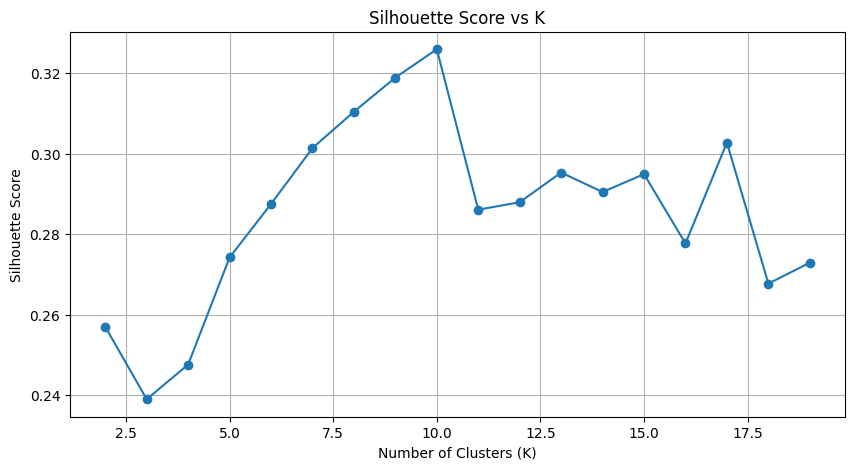

Best K by silhouette = 10


In [68]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np

# -------------------------
# 1. Select quality_scaled columns
# -------------------------
quality_cols = [c for c in final_pitch_table.columns if c.endswith("_quality_scaled")]

X = final_pitch_table[quality_cols].fillna(0)   # safe fill


# -------------------------
# 2. Compute silhouette for K = 2 to K = 10
# -------------------------
Ks = range(2, 20)
sil_scores = []

for k in Ks:
    km = KMeans(n_clusters=k, n_init=20, random_state=42)
    labels = km.fit_predict(X)
    sil = silhouette_score(X, labels)
    sil_scores.append(sil)
    print(f"K={k}  silhouette={sil:.4f}")


# -------------------------
# 3. Plot silhouette scores
# -------------------------
plt.figure(figsize=(10, 5))
plt.plot(Ks, sil_scores, marker='o')
plt.title("Silhouette Score vs K")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()


# -------------------------
# 4. Fit final KMeans with best K (you choose)
# Example: K=5
# -------------------------
best_K = Ks[np.argmax(sil_scores)]
print(f"Best K by silhouette = {best_K}")

kmeans_final = KMeans(n_clusters=best_K, n_init=20, random_state=42)
final_pitch_table["kmeans_quality_cluster"] = kmeans_final.fit_predict(X)


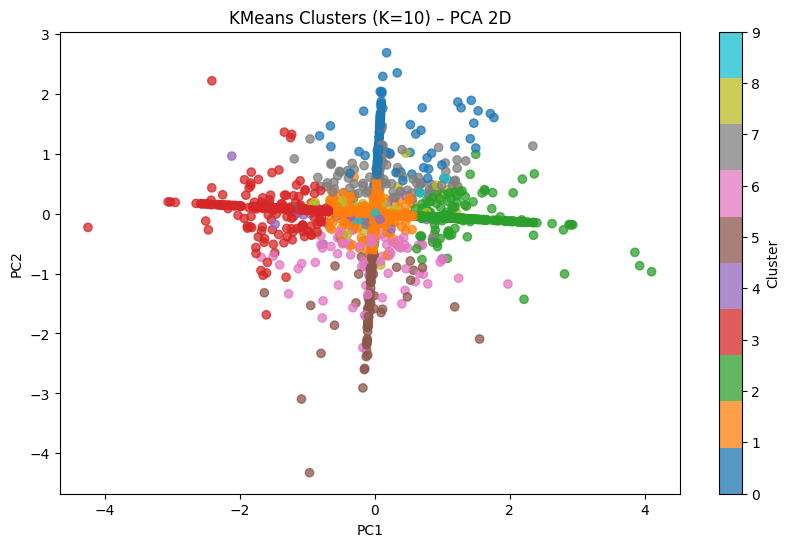

In [69]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# -------------------------
# 0. Extract the quality_scaled matrix
# -------------------------
quality_cols = [c for c in final_pitch_table.columns if c.endswith("_quality_scaled")]
X = final_pitch_table[quality_cols].fillna(0)

# -------------------------
# 1. Run KMeans with K=10
# -------------------------
kmeans = KMeans(n_clusters=10, n_init=20, random_state=42)
labels = kmeans.fit_predict(X)

final_pitch_table["kmeans_quality_cluster"] = labels

# -------------------------
# 2. PCA to 2D
# -------------------------
pca_2d = PCA(n_components=2)
X_2d = pca_2d.fit_transform(X)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, cmap='tab10', alpha=0.75)
plt.title("KMeans Clusters (K=10) – PCA 2D")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(scatter, label="Cluster")


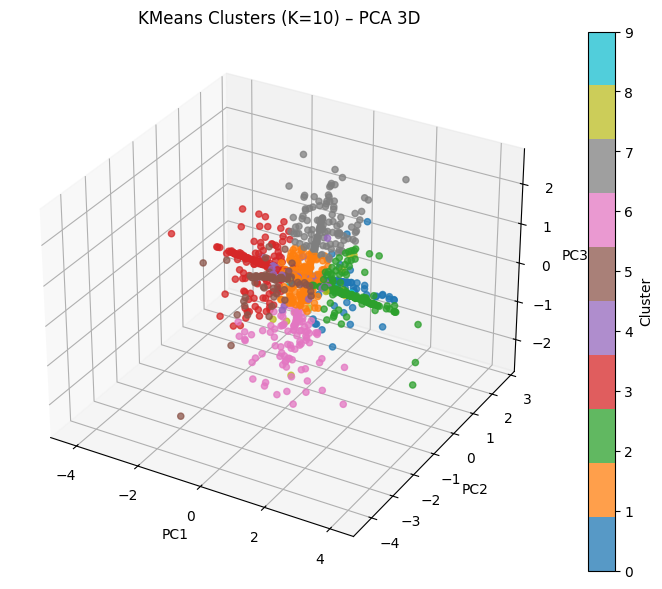

In [70]:
# -------------------------
# 3. PCA to 3D
# -------------------------
pca_3d = PCA(n_components=3)
X_3d = pca_3d.fit_transform(X)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

p = ax.scatter(X_3d[:, 0], X_3d[:, 1], X_3d[:, 2],
               c=labels, cmap='tab10', alpha=0.75)

ax.set_title("KMeans Clusters (K=10) – PCA 3D")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")

fig.colorbar(p, label="Cluster")
plt.show()


In [71]:
# -------------------------
# 4. Compute cluster centroids for *_quality_scaled
# -------------------------
centroids = pd.DataFrame(
    kmeans.cluster_centers_,
    columns=quality_cols
)
centroids["cluster"] = centroids.index

print("\n=== CENTROIDS of PITCH QUALITY SCALED ===\n")
print(centroids)


=== CENTROIDS of PITCH QUALITY SCALED ===

   CH_quality_scaled  CU_quality_scaled  FC_quality_scaled  FF_quality_scaled  \
0           0.032266           0.008224           0.013824           0.135107   
1           0.000473          -0.017207          -0.060897          -0.019740   
2          -0.004100           0.030828          -0.001151           1.209707   
3          -0.003555          -0.011929          -0.020258          -1.330298   
4          -1.511750          -0.103016          -0.097874          -0.139830   
5          -0.042818           0.020734          -0.024782           0.007748   
6          -0.006023           0.025413          -0.003141           0.021695   
7           0.006312           0.040161          -0.036763           0.096945   
8           1.580774           0.011905           0.004135           0.032097   
9          -0.022927           0.023513           1.440648           0.025286   

   FS_quality_scaled  SI_quality_scaled  SL_quality_scaled  ST_q

In [72]:
cluster_name_map = {
    0: "Fastball Generalists (Good FF + Good SI)",
    1: "League-Average Pitch Quality",
    2: "Four-Seam Aces (Elite FF Quality)",
    3: "Weak Fastball Group (Bad FF)",
    4: "Poor Changeup Group (Bad CH)",
    5: "Sinkers Get Hit (Bad SI)",
    6: "Weak Breaking Ball Group (Bad SL)",
    7: "Slider Aces (Elite SL)",
    8: "Changeup Specialists (Elite CH)",
    9: "Cutter Aces (Elite FC)"
}


In [73]:
final_pitch_table["quality_archetype"] = (
    final_pitch_table["kmeans_quality_cluster"].map(cluster_name_map)
)


In [74]:
final_pitch_table.head()

final_pitch_table[final_pitch_table["last_name, first_name"] == "Skubal, Tarik"]

pitch_type,player_id,year,"last_name, first_name",CH_pct,CU_pct,FC_pct,FF_pct,FS_pct,KN_pct,SI_pct,...,CU_quality_scaled,FC_quality_scaled,FF_quality_scaled,FS_quality_scaled,SI_quality_scaled,SL_quality_scaled,ST_quality_scaled,SV_quality_scaled,kmeans_quality_cluster,quality_archetype
1879,669373,2020,"Skubal, Tarik",NaN,NaN,NaN,0.589,NaN,NaN,NaN,...,NaN,NaN,0.877666,NaN,NaN,NaN,NaN,NaN,2,Four-Seam Aces (Elite FF Quality)
1880,669373,2021,"Skubal, Tarik",NaN,NaN,NaN,0.429,NaN,NaN,NaN,...,NaN,NaN,-1.679873,NaN,NaN,0.351931,NaN,NaN,3,Weak Fastball Group (Bad FF)
1881,669373,2022,"Skubal, Tarik",NaN,NaN,NaN,0.266,NaN,NaN,0.212,...,NaN,NaN,0.391588,NaN,0.704549,-0.122609,NaN,NaN,0,Fastball Generalists (Good FF + Good SI)
1882,669373,2023,"Skubal, Tarik",NaN,NaN,NaN,0.360,NaN,NaN,NaN,...,NaN,NaN,2.408503,NaN,NaN,NaN,NaN,NaN,2,Four-Seam Aces (Elite FF Quality)
1883,669373,2024,"Skubal, Tarik",0.270,NaN,NaN,0.332,NaN,NaN,0.206,...,NaN,NaN,1.396134,NaN,2.065430,-0.681806,NaN,NaN,0,Fastball Generalists (Good FF + Good SI)
1884,669373,2025,"Skubal, Tarik",0.314,NaN,NaN,0.295,NaN,NaN,0.237,...,NaN,NaN,0.877702,NaN,0.471879,NaN,NaN,NaN,8,Changeup Specialists (Elite CH)


In [75]:
pitcher_quality_clusters = final_pitch_table.copy()

## Clustering using quality by xwoba weighted by usage

In [76]:
my_df = final_pitch_table.copy()

import pandas as pd
import numpy as np

df = my_df.copy()   # your new dataframe

# Identify usage pct and scaled quality columns
pct_cols = [c for c in df.columns if c.endswith("_pct")]
qual_cols = [c for c in df.columns if c.endswith("_quality_scaled")]

# Build a mapping from pitch_type_pct → pitch_type_quality_scaled
impact_cols = {}

for pct_col in pct_cols:
    pitch = pct_col.replace("_pct", "")
    qual_col = pitch + "_quality_scaled"
    if qual_col in df.columns:
        impact_col = pitch + "_impact"
        df[impact_col] = df[pct_col] * df[qual_col]
        impact_cols[pitch] = impact_col

print("Created impact columns:", list(impact_cols.values()))


Created impact columns: ['CH_impact', 'CU_impact', 'FC_impact', 'FF_impact', 'FS_impact', 'SI_impact', 'SL_impact', 'ST_impact', 'SV_impact']


K=2  silhouette=0.3014
K=3  silhouette=0.2774
K=4  silhouette=0.3082
K=5  silhouette=0.3215
K=6  silhouette=0.3397
K=7  silhouette=0.2954
K=8  silhouette=0.3123
K=9  silhouette=0.2945
K=10  silhouette=0.3127


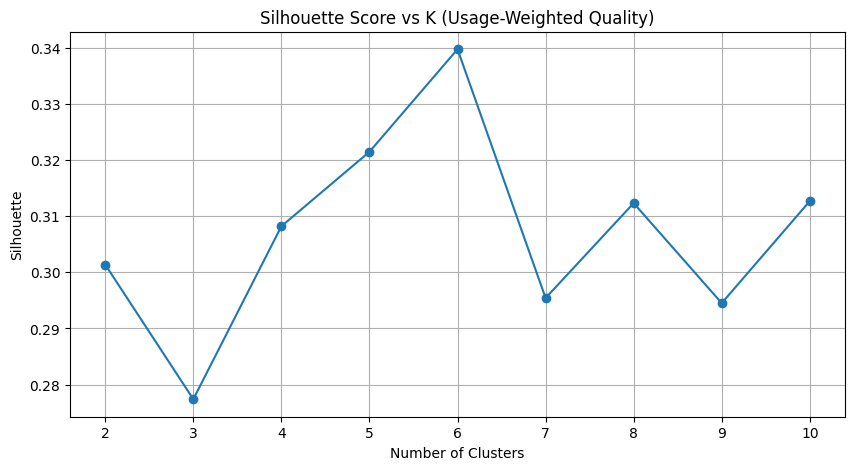

Best K = 6


In [77]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Use only impact columns
impact_feature_cols = [c for c in df.columns if c.endswith("_impact")]
X = df[impact_feature_cols].fillna(0)

Ks = range(2, 11)
sil_scores = []

for k in Ks:
    km = KMeans(n_clusters=k, n_init=20, random_state=42)
    labels = km.fit_predict(X)
    sil = silhouette_score(X, labels)
    sil_scores.append(sil)
    print(f"K={k}  silhouette={sil:.4f}")

# Plot silhouette scores
plt.figure(figsize=(10, 5))
plt.plot(Ks, sil_scores, marker='o')
plt.title("Silhouette Score vs K (Usage-Weighted Quality)")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette")
plt.grid(True)
plt.show()

best_K = Ks[np.argmax(sil_scores)]
print("Best K =", best_K)


In [78]:
kmeans_final = KMeans(n_clusters=best_K, n_init=20, random_state=42)
df["impact_cluster"] = kmeans_final.fit_predict(X)


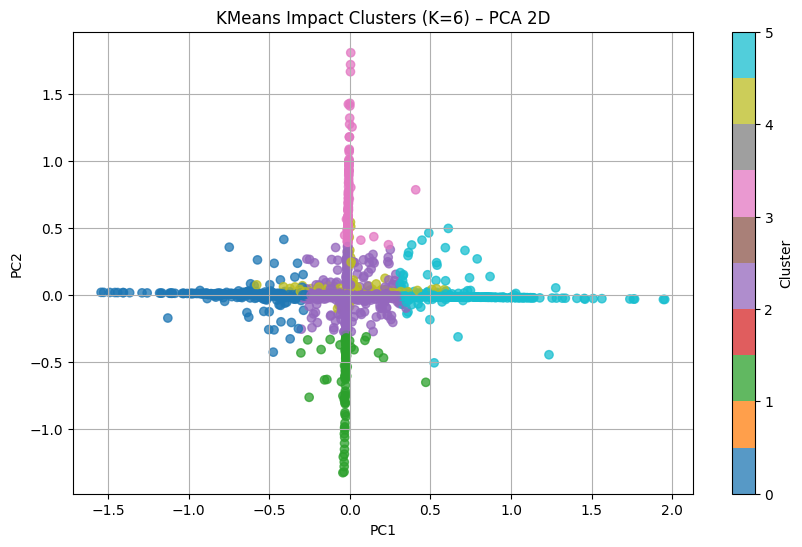

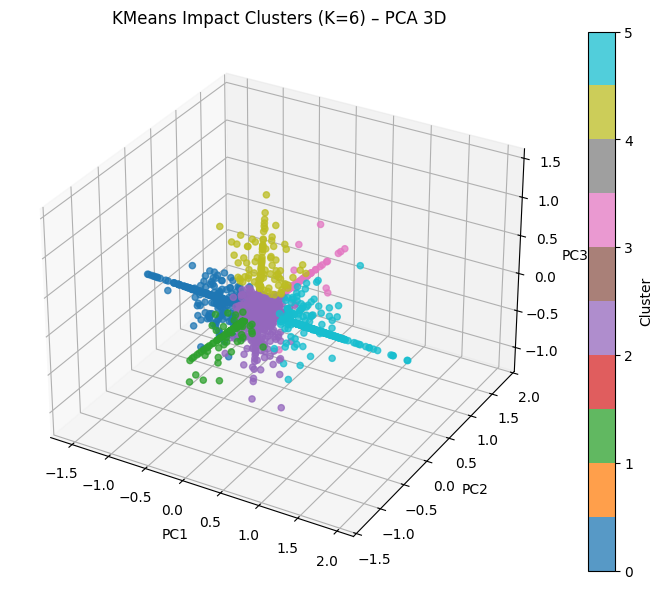

In [79]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

# ---- PCA 2D ----
pca2 = PCA(n_components=2)
X2 = pca2.fit_transform(X)

plt.figure(figsize=(10, 6))
plt.scatter(X2[:,0], X2[:,1], c=df["impact_cluster"], cmap="tab10", alpha=0.75)
plt.title(f"KMeans Impact Clusters (K={best_K}) – PCA 2D")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.colorbar(label="Cluster")
plt.show()

# ---- PCA 3D ----
pca3 = PCA(n_components=3)
X3 = pca3.fit_transform(X)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

p = ax.scatter(X3[:,0], X3[:,1], X3[:,2],
               c=df["impact_cluster"], cmap='tab10', alpha=0.75)

ax.set_title(f"KMeans Impact Clusters (K={best_K}) – PCA 3D")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")

fig.colorbar(p, label="Cluster")
plt.show()


In [80]:
centroids_impact = pd.DataFrame(
    kmeans_final.cluster_centers_,
    columns=impact_feature_cols
)
centroids_impact["cluster"] = centroids_impact.index

print("\n=== CENTROIDS (Impact Metrics) ===")
print(centroids_impact)



=== CENTROIDS (Impact Metrics) ===
   CH_impact  CU_impact  FC_impact  FF_impact  FS_impact  SI_impact  \
0   0.001754  -0.003159  -0.003424  -0.534281  -0.003642  -0.002225   
1  -0.015544   0.003466   0.008290   0.000138  -0.002254  -0.560872   
2   0.008415  -0.001631   0.007084   0.018807   0.002353   0.001347   
3  -0.000086   0.002550  -0.002698   0.009234  -0.001052   0.741334   
4  -0.002837   0.002501  -0.013008   0.014273  -0.000770   0.022590   
5   0.001665   0.007960   0.005474   0.643794  -0.001090   0.010229   

   SL_impact     ST_impact     SV_impact  cluster  
0  -0.019692  7.569071e-04 -1.104424e-03        0  
1  -0.028891  5.331370e-03 -4.013929e-03        1  
2  -0.031549 -1.042339e-03  8.175671e-04        2  
3  -0.005991 -5.463156e-03  0.000000e+00        3  
4   0.556572 -5.421011e-20  2.710505e-20        4  
5   0.017079  4.029932e-03  8.789218e-04        5  


In [81]:
impact_cluster_name_map = {
    0: "FF Liability Pitchers (Bad Fastball Impact)",
    1: "Sinker Liability Pitchers (Sinker Gets Crushed)",
    2: "Balanced Positive Arsenal (Mild Impact Gains)",
    3: "Sinker Aces (Elite Sinker Impact)",
    4: "Slider Aces (Elite Slider Impact)",
    5: "Four-Seam Aces (Elite FF Impact)"
}


In [82]:
df["impact_archetype"] = df["impact_cluster"].map(impact_cluster_name_map)


In [83]:
df[df["last_name, first_name"] == "Ohtani, Shohei"]

pitch_type,player_id,year,"last_name, first_name",CH_pct,CU_pct,FC_pct,FF_pct,FS_pct,KN_pct,SI_pct,...,CU_impact,FC_impact,FF_impact,FS_impact,SI_impact,SL_impact,ST_impact,SV_impact,impact_cluster,impact_archetype
1580,660271,2021,"Ohtani, Shohei",NaN,NaN,NaN,0.440,NaN,NaN,NaN,...,NaN,NaN,-0.289584,NaN,NaN,NaN,-0.067513,NaN,0,FF Liability Pitchers (Bad Fastball Impact)
1581,660271,2022,"Ohtani, Shohei",NaN,NaN,NaN,0.273,NaN,NaN,NaN,...,NaN,NaN,-0.037927,NaN,NaN,NaN,0.098744,NaN,2,Balanced Positive Arsenal (Mild Impact Gains)
1582,660271,2023,"Ohtani, Shohei",NaN,NaN,NaN,0.329,NaN,NaN,NaN,...,NaN,NaN,0.158886,NaN,NaN,NaN,0.058010,NaN,2,Balanced Positive Arsenal (Mild Impact Gains)


In [84]:
pitcher_impact_clusters = df.copy()

## Final pitcher archetypes

Final Selected clusters

### Impact ((average_xwoba - xwoba ) * usage rate)

In [85]:
print(len(pitcher_quality_clusters), len(pitcher_impact_clusters), len(pitch_df))


2225 2225 2484


In [86]:
print("Unique Impact Clusters:")
unique_impact = pitcher_impact_clusters[["impact_cluster", "impact_archetype"]].drop_duplicates()
print(unique_impact)



Unique Impact Clusters:
pitch_type  impact_cluster                                 impact_archetype
0                        2    Balanced Positive Arsenal (Mild Impact Gains)
5                        1  Sinker Liability Pitchers (Sinker Gets Crushed)
6                        5                 Four-Seam Aces (Elite FF Impact)
7                        0      FF Liability Pitchers (Bad Fastball Impact)
16                       4                Slider Aces (Elite Slider Impact)
25                       3                Sinker Aces (Elite Sinker Impact)


In [87]:
# Identify all impact feature columns
impact_cols = [c for c in pitcher_impact_clusters.columns if c.endswith("_impact")]

# Create a total impact column
pitcher_impact_clusters["total_impact"] = pitcher_impact_clusters[impact_cols].sum(axis=1)

# Top 1 pitcher per cluster
top_per_cluster = (
    pitcher_impact_clusters
    .sort_values("total_impact", ascending=False)
    .groupby("impact_cluster")
    .head(1)    # top 1 per group
    .reset_index(drop=True)
)

print("\n=== TOP 1 PITCHER PER IMPACT CLUSTER ===")
top_per_cluster[[
    "impact_cluster",
    "impact_archetype",
    "last_name, first_name",
    "year",
    "total_impact"
]]



=== TOP 1 PITCHER PER IMPACT CLUSTER ===


pitch_type,impact_cluster,impact_archetype,"last_name, first_name",year,total_impact
0,5,Four-Seam Aces (Elite FF Impact),"deGrom, Jacob",2021,2.223735
1,2,Balanced Positive Arsenal (Mild Impact Gains),"Williams, Devin",2020,2.163517
2,3,Sinker Aces (Elite Sinker Impact),"Kolarek, Adam",2020,1.818238
3,4,Slider Aces (Elite Slider Impact),"Muñoz, Andrés",2022,1.447381
4,1,Sinker Liability Pitchers (Sinker Gets Crushed),"Alvarado, José",2024,0.725705
5,0,FF Liability Pitchers (Bad Fastball Impact),"Richards, Trevor",2024,0.395931


In [88]:
# Worst (lowest impact) pitcher in each cluster
worst_per_cluster = (
    pitcher_impact_clusters
    .sort_values("total_impact", ascending=True)   # smallest (worst) first
    .groupby("impact_cluster")
    .head(1)
    .reset_index(drop=True)
)

print("=== WORST 1 PITCHER PER IMPACT CLUSTER ===")
worst_per_cluster[
    ["impact_cluster", "impact_archetype", "last_name, first_name", "year", "total_impact"]
]


=== WORST 1 PITCHER PER IMPACT CLUSTER ===


pitch_type,impact_cluster,impact_archetype,"last_name, first_name",year,total_impact
0,2,Balanced Positive Arsenal (Mild Impact Gains),"Brewer, Colten",2020,-1.918697
1,0,FF Liability Pitchers (Bad Fastball Impact),"Bumgarner, Madison",2020,-1.716059
2,1,Sinker Liability Pitchers (Sinker Gets Crushed),"Cobb, Alex",2020,-1.655248
3,5,Four-Seam Aces (Elite FF Impact),"Darvish, Yu",2021,-0.440366
4,3,Sinker Aces (Elite Sinker Impact),"Quantrill, Cal",2020,-0.228877
5,4,Slider Aces (Elite Slider Impact),"Canning, Griffin",2020,-0.132217


### Quality (average_xwoba - xwoba)

In [89]:
# === UNIQUE QUALITY CLUSTERS ===
print("Unique Quality Clusters:")
unique_quality = pitcher_quality_clusters[["kmeans_quality_cluster", "quality_archetype"]].drop_duplicates()
print(unique_quality)

Unique Quality Clusters:
pitch_type  kmeans_quality_cluster                         quality_archetype
0                                6         Weak Breaking Ball Group (Bad SL)
1                                5                  Sinkers Get Hit (Bad SI)
2                                1              League-Average Pitch Quality
3                                0  Fastball Generalists (Good FF + Good SI)
6                                2         Four-Seam Aces (Elite FF Quality)
7                                8           Changeup Specialists (Elite CH)
9                                3              Weak Fastball Group (Bad FF)
16                               7                    Slider Aces (Elite SL)
27                               9                    Cutter Aces (Elite FC)
57                               4              Poor Changeup Group (Bad CH)


In [90]:
# === TOTAL QUALITY SCORE ===
# all quality_scaled columns
quality_cols = [c for c in pitcher_quality_clusters.columns if c.endswith("_quality_scaled")]

# compute total quality
pitcher_quality_clusters["total_quality"] = pitcher_quality_clusters[quality_cols].sum(axis=1)

In [91]:
# === TOP 1 PITCHER PER QUALITY CLUSTER ===
top_quality_per_cluster = (
    pitcher_quality_clusters
    .sort_values("total_quality", ascending=False)
    .groupby("kmeans_quality_cluster")
    .head(1)
    .reset_index(drop=True)
)

print("\n=== TOP 1 PITCHER PER QUALITY CLUSTER ===")

top_quality_per_cluster[
    ["kmeans_quality_cluster", "quality_archetype", "last_name, first_name", "year", "total_quality"]
]



=== TOP 1 PITCHER PER QUALITY CLUSTER ===


pitch_type,kmeans_quality_cluster,quality_archetype,"last_name, first_name",year,total_quality
0,2,Four-Seam Aces (Elite FF Quality),"Bauer, Trevor",2020,5.592199
1,7,Slider Aces (Elite SL),"deGrom, Jacob",2021,5.069467
2,9,Cutter Aces (Elite FC),"Crochet, Garrett",2025,4.674799
3,0,Fastball Generalists (Good FF + Good SI),"Wheeler, Zack",2021,4.578361
4,8,Changeup Specialists (Elite CH),"Williams, Devin",2020,4.117381
5,1,League-Average Pitch Quality,"Buehler, Walker",2021,2.742856
6,3,Weak Fastball Group (Bad FF),"Snell, Blake",2023,2.158689
7,6,Weak Breaking Ball Group (Bad SL),"Gilbert, Logan",2025,1.668650
8,5,Sinkers Get Hit (Bad SI),"Valdez, Framber",2020,0.844305
9,4,Poor Changeup Group (Bad CH),"Manaea, Sean",2022,-0.267020


In [92]:
# === WORST 1 PITCHER PER QUALITY CLUSTER ===
worst_quality_per_cluster = (
    pitcher_quality_clusters
    .sort_values("total_quality", ascending=True)
    .groupby("kmeans_quality_cluster")
    .head(1)
    .reset_index(drop=True)
)

print("\n=== WORST 1 PITCHER PER QUALITY CLUSTER ===")

worst_quality_per_cluster[
    ["kmeans_quality_cluster", "quality_archetype", "last_name, first_name", "year", "total_quality"]
]



=== WORST 1 PITCHER PER QUALITY CLUSTER ===


pitch_type,kmeans_quality_cluster,quality_archetype,"last_name, first_name",year,total_quality
0,5,Sinkers Get Hit (Bad SI),"Roark, Tanner",2020,-7.238099
1,1,League-Average Pitch Quality,"Brewer, Colten",2020,-4.889249
2,3,Weak Fastball Group (Bad FF),"Pfaadt, Brandon",2025,-4.817085
3,4,Poor Changeup Group (Bad CH),"Matz, Steven",2020,-4.745319
4,6,Weak Breaking Ball Group (Bad SL),"Gomber, Austin",2024,-4.351694
5,2,Four-Seam Aces (Elite FF Quality),"Lauer, Eric",2022,-2.967567
6,0,Fastball Generalists (Good FF + Good SI),"Darvish, Yu",2023,-1.078772
7,7,Slider Aces (Elite SL),"Myers, Tobias",2024,-1.053976
8,9,Cutter Aces (Elite FC),"Walker, Taijuan",2025,-0.620608
9,8,Changeup Specialists (Elite CH),"Greinke, Zack",2021,-0.478752


### Adding handedness

In [93]:
print(pitch_df.columns.tolist())


['last_name, first_name', 'pitcher', 'four_seam', 'sinker', 'cutter', 'slider', 'changeup', 'curveball', 'splitter', 'knuckleball', 'sweeper', 'screwball', 'year', 'handedness', 'total_pitches', 'four_seam_pct', 'sinker_pct', 'cutter_pct', 'slider_pct', 'changeup_pct', 'curveball_pct', 'splitter_pct', 'knuckleball_pct', 'sweeper_pct', 'screwball_pct', 'kmeans_cluster', 'hac_cluster', 'hac_archetype']


In [94]:
pitcher_quality_clusters = pitcher_quality_clusters.merge(
    pitch_df[["pitcher", "year", "handedness"]].drop_duplicates(),
    left_on=["player_id", "year"],
    right_on=["pitcher", "year"],
    how="left"
)

# Optional cleanup — remove duplicate 'pitcher' col
pitcher_quality_clusters = pitcher_quality_clusters.drop(columns=["pitcher"])


In [95]:
pitcher_impact_clusters = pitcher_impact_clusters.merge(
    pitch_df[["pitcher", "year", "handedness"]].drop_duplicates(),
    left_on=["player_id", "year"],
    right_on=["pitcher", "year"],
    how="left"
)

pitcher_impact_clusters = pitcher_impact_clusters.drop(columns=["pitcher"])


### Test again

In [96]:
print(len(pitcher_quality_clusters), len(pitcher_impact_clusters), len(pitch_df))

2225 2225 2484


In [97]:
pitcher_quality_clusters.head()

,player_id,year,"last_name, first_name",CH_pct,CU_pct,FC_pct,FF_pct,FS_pct,KN_pct,SI_pct,...,FF_quality_scaled,FS_quality_scaled,SI_quality_scaled,SL_quality_scaled,ST_quality_scaled,SV_quality_scaled,kmeans_quality_cluster,quality_archetype,total_quality,handedness
0,282332,2019,"Sabathia, CC",NaN,NaN,0.420,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-0.720779,NaN,NaN,6,Weak Breaking Ball Group (Bad SL),-1.126072,L
1,425794,2019,"Wainwright, Adam",NaN,0.368,0.224,NaN,NaN,NaN,0.251,...,NaN,NaN,-0.901292,NaN,NaN,NaN,5,Sinkers Get Hit (Bad SI),-1.945154,R
2,425794,2020,"Wainwright, Adam",NaN,0.383,0.229,NaN,NaN,NaN,0.271,...,NaN,NaN,0.325371,NaN,NaN,NaN,1,League-Average Pitch Quality,-0.361943,R
3,425794,2021,"Wainwright, Adam",NaN,0.341,0.217,NaN,NaN,NaN,0.281,...,NaN,NaN,1.177386,NaN,NaN,NaN,0,Fastball Generalists (Good FF + Good SI),0.188888,R
4,425794,2022,"Wainwright, Adam",NaN,0.317,0.250,NaN,NaN,NaN,0.279,...,NaN,NaN,-0.272013,NaN,NaN,NaN,1,League-Average Pitch Quality,-1.578765,R


In [98]:
pitcher_impact_clusters.head()

,player_id,year,"last_name, first_name",CH_pct,CU_pct,FC_pct,FF_pct,FS_pct,KN_pct,SI_pct,...,FF_impact,FS_impact,SI_impact,SL_impact,ST_impact,SV_impact,impact_cluster,impact_archetype,total_impact,handedness
0,282332,2019,"Sabathia, CC",NaN,NaN,0.420,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-0.217675,NaN,NaN,2,Balanced Positive Arsenal (Mild Impact Gains),-0.387898,L
1,425794,2019,"Wainwright, Adam",NaN,0.368,0.224,NaN,NaN,NaN,0.251,...,NaN,NaN,-0.226224,NaN,NaN,NaN,2,Balanced Positive Arsenal (Mild Impact Gains),-0.488124,R
2,425794,2020,"Wainwright, Adam",NaN,0.383,0.229,NaN,NaN,NaN,0.271,...,NaN,NaN,0.088175,NaN,NaN,NaN,2,Balanced Positive Arsenal (Mild Impact Gains),-0.036437,R
3,425794,2021,"Wainwright, Adam",NaN,0.341,0.217,NaN,NaN,NaN,0.281,...,NaN,NaN,0.330845,NaN,NaN,NaN,2,Balanced Positive Arsenal (Mild Impact Gains),0.064239,R
4,425794,2022,"Wainwright, Adam",NaN,0.317,0.250,NaN,NaN,NaN,0.279,...,NaN,NaN,-0.075892,NaN,NaN,NaN,2,Balanced Positive Arsenal (Mild Impact Gains),-0.443863,R


## Combine the final clusters so we have pitchers by quality of their pitcher, and also pitch impact on game

In [99]:
combined_clusters = pitcher_quality_clusters.merge(
    pitcher_impact_clusters[
        ["player_id", "year", "impact_cluster", "impact_archetype"]
    ],
    on=["player_id", "year"],
    how="inner"
)

print("Combined shape:", combined_clusters.shape)
combined_clusters.head()


Combined shape: (2225, 48)


,player_id,year,"last_name, first_name",CH_pct,CU_pct,FC_pct,FF_pct,FS_pct,KN_pct,SI_pct,...,SI_quality_scaled,SL_quality_scaled,ST_quality_scaled,SV_quality_scaled,kmeans_quality_cluster,quality_archetype,total_quality,handedness,impact_cluster,impact_archetype
0,282332,2019,"Sabathia, CC",NaN,NaN,0.420,NaN,NaN,NaN,NaN,...,NaN,-0.720779,NaN,NaN,6,Weak Breaking Ball Group (Bad SL),-1.126072,L,2,Balanced Positive Arsenal (Mild Impact Gains)
1,425794,2019,"Wainwright, Adam",NaN,0.368,0.224,NaN,NaN,NaN,0.251,...,-0.901292,NaN,NaN,NaN,5,Sinkers Get Hit (Bad SI),-1.945154,R,2,Balanced Positive Arsenal (Mild Impact Gains)
2,425794,2020,"Wainwright, Adam",NaN,0.383,0.229,NaN,NaN,NaN,0.271,...,0.325371,NaN,NaN,NaN,1,League-Average Pitch Quality,-0.361943,R,2,Balanced Positive Arsenal (Mild Impact Gains)
3,425794,2021,"Wainwright, Adam",NaN,0.341,0.217,NaN,NaN,NaN,0.281,...,1.177386,NaN,NaN,NaN,0,Fastball Generalists (Good FF + Good SI),0.188888,R,2,Balanced Positive Arsenal (Mild Impact Gains)
4,425794,2022,"Wainwright, Adam",NaN,0.317,0.250,NaN,NaN,NaN,0.279,...,-0.272013,NaN,NaN,NaN,1,League-Average Pitch Quality,-1.578765,R,2,Balanced Positive Arsenal (Mild Impact Gains)


In [101]:
import pandas as pd

# Select only the columns you want
pitcher_cols = [
    'player_id',
    'year',
    'last_name, first_name',
    'kmeans_quality_cluster',
    'quality_archetype',
    'impact_cluster',
    'impact_archetype'
]

pitchers_final = combined_clusters[pitcher_cols].copy()

# Save to CSV
pitchers_final.to_csv("Pitchers_With_Clusters.csv", index=False)

print("Saved Pitchers_With_Clusters.csv with shape:", pitchers_final.shape)


Saved Pitchers_With_Clusters.csv with shape: (2225, 7)
